# Support Vector Machine Predictive Model for EDTA QC: Part 2 – Final model generation, validation, safe-threshold definition, and visualization

We built a Support Vector Machine (SVM) classifier using scikit-learn. The TRAIN-165 dataset (165 samples) was used for model development. Class 1 represents samples of good mRNA quality, while class 0 represents samples of poor mRNA quality.


Contents:

- **Data Preprocessing Before Loading**

- **Module Imports**

- **Importing and Processing data**
    - Importing data
    - Splitting the data into independent and dependent variables
    
 - **Building the Final SVM pipeline**
    - Final model fit on the full TRAIN-165 set (without 23 holdouts)
    - Final support vectors
    - Summary for final model training and saving

 - **Evaluation on External Test Sets**
    - Reloading the saved final model from joblib
    - Data preprocessing - TRAIN-165, TEST1-23 and TEST2-R23
    - Splitting into dependent and independent variables
    - Decision scores
    - Safe threshold determination
    - TEST2-R23 metrics
    - TEST1-23 evaluation
    - TEST1-23 prediction values
    - Visualization of safe threshold

----
----

#### **Data Preprocessing Before Loading**

- Any samples with missing data were excluded. 
- Data were normalized using three reference genes: GAPDH, GUSB, and PPIB (sequences of optimized primers can be found at https://pubmed.ncbi.nlm.nih.gov/25369468/).
- Data were checked for outliers, which were excluded (no outliers are allowed in the training data). 
- In Genex Enterprise (MultiD), SOM analysis identified clerly distinguished two classes in the training set.

----
----

#### **Module Import**

In [1]:
import joblib
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from IPython.display import display
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display
from matplotlib.lines import Line2D

In [2]:
# ── Setup paths relative to project root ──
cwd = Path().cwd()
ROOT = cwd
while not (ROOT / "README.md").exists():
    ROOT = ROOT.parent

DATA_DIR = ROOT / "data"
MODELS_DIR = ROOT / "models"
NB_OUTPUT = ROOT / "notebooks" / "outputs_from_notebooks"
VERSIONS_DIR = MODELS_DIR / "versions"

# Create folders if needed
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
NB_OUTPUT.mkdir(parents=True, exist_ok=True)
VERSIONS_DIR.mkdir(parents=True, exist_ok=True)

# Paths to data
TRAIN_PATH  = DATA_DIR / "train_165_data.csv"
TEST1_PATH = DATA_DIR / "test1_data.csv"
TEST2_PATH = DATA_DIR / "test2_data.csv"
THRESHOLD_PATH = MODELS_DIR / "safe_threshold.json"

MODEL_PATH = MODELS_DIR / "final_pipeline_v1_2025-12-09.joblib" # for manual changing
PCA2_PATH = MODELS_DIR / "pca2.joblib" # for manual changing

print("ROOT:", ROOT)
print("TRAIN_PATH  exists:", TRAIN_PATH .exists())
print("TEST1_PATH:", TEST1_PATH, "Exists?", TEST1_PATH.exists())
print("TEST2_PATH:", TEST2_PATH, "Exists?", TEST2_PATH.exists())
print("MODEL_PATH:", MODEL_PATH, "Exists?", MODEL_PATH.exists())

ROOT: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce
TRAIN_PATH  exists: True
TEST1_PATH: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\data\test1_data.csv Exists? True
TEST2_PATH: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\data\test2_data.csv Exists? True
MODEL_PATH: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\models\final_pipeline_v1_2025-12-09.joblib Exists? True


#### Directory Structure Overview (optional)  

In [3]:
print("ROOT:", ROOT)
print("DEV_DATA_PATH:", TRAIN_PATH)
print("Exists?", TRAIN_PATH.exists())

ROOT: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce
DEV_DATA_PATH: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\data\train_165_data.csv
Exists? True


----
----

#### **Importing and Processing data**

#### Task 1: Importing data

In [4]:
# Developmental set
train_165_df = pd.read_csv(TRAIN_PATH, index_col=0)

# Map binary class labels to text for convenience
train_165_df["label_text"] = train_165_df["groups"].map({1: "OK", 0: "POOR"})

# Select only feature columns
feature_cols_train = train_165_df.columns.drop(["groups", "label_text"])


In [5]:
train_165_df.head()

,BTG3,CD69,CXCR1,CXCR2,FCGR3A,JUN,STEAP4,groups,label_text
sample,,,,,,,,,
1 EDTA val T0,5.480000,6.920000,-1.510000,-0.850000,-3.650000,3.150000,-0.310000,1,OK
1 EDTA val T24,2.840000,3.260000,0.730000,2.020000,-1.450000,-2.150000,1.600000,0,POOR
1 EDTA val T48,2.306667,2.186667,2.896667,4.296667,0.866667,-3.573333,3.996667,0,POOR
10 EDTA val T0,4.506667,5.486667,-2.143333,-0.913333,-3.443333,1.566667,-0.833333,1,OK
10 EDTA val T24,3.060000,2.230000,0.500000,1.790000,-1.380000,-2.340000,1.320000,0,POOR


In [6]:
train_165_df["label_text"].value_counts()


label_text
POOR    109
OK       56
Name: count, dtype: int64

In [7]:
print(train_165_df.shape)
print(train_165_df.columns.tolist())
print(train_165_df.isna().sum())

(165, 9)
['BTG3', 'CD69', 'CXCR1', 'CXCR2', 'FCGR3A', 'JUN', 'STEAP4', 'groups', 'label_text']
BTG3          0
CD69          0
CXCR1         0
CXCR2         0
FCGR3A        0
JUN           0
STEAP4        0
groups        0
label_text    0
dtype: int64


----

#### Task 2:  Splitting the data into independent and dependent variables

In [8]:
# Split into X and y
X_train = train_165_df[feature_cols_train]
y_train = train_165_df["groups"].astype(int)

In [9]:
X_train.head()

,BTG3,CD69,CXCR1,CXCR2,FCGR3A,JUN,STEAP4
sample,,,,,,,
1 EDTA val T0,5.480000,6.920000,-1.510000,-0.850000,-3.650000,3.150000,-0.310000
1 EDTA val T24,2.840000,3.260000,0.730000,2.020000,-1.450000,-2.150000,1.600000
1 EDTA val T48,2.306667,2.186667,2.896667,4.296667,0.866667,-3.573333,3.996667
10 EDTA val T0,4.506667,5.486667,-2.143333,-0.913333,-3.443333,1.566667,-0.833333
10 EDTA val T24,3.060000,2.230000,0.500000,1.790000,-1.380000,-2.340000,1.320000


In [10]:
y_train.head()

sample
1 EDTA val T0      1
1 EDTA val T24     0
1 EDTA val T48     0
10 EDTA val T0     1
10 EDTA val T24    0
Name: groups, dtype: int64

Group 0: samples with altered gene expression = poor samples
Group 1: samples at time 0 = good samples

----
----

#### **Building the Final SVM pipeline**

#### Task 3: Final model fit on the full TRAIN-165 set (without 23 holdouts)

In this step **the final version of the SVM model is trained** on the complete training dataset with 165 samples.

⚠️ **MODEL VERSIONING ENABLED**

- If you have changed any part of the **data**, **feature processing**, or **model parameters**, a new version of the model should be saved to preserve reproducibility.
- The code will automatically check the `models/versions/` folder for any previously saved versions.
- You will see information about the **latest saved model version** (e.g., `final_pipeline_prob_v3_2025-09-04.joblib`).
- You will be **prompted to confirm** whether a new version should be saved using an interactive toggle (✅ yes / ❌ no).
- If you confirm, a new file will be created (e.g., `final_pipeline_prob_v4_2025-09-04.joblib`), and stored in `models/versions/`.

📌 The **active model used by applications** remains in folder MODELS unless updated manually.

This versioned saving mechanism ensures previous models are not accidentally overwritten and allows you to maintain a clean, traceable history of all trained versions.
The data for training comes from train_165_data.csv, where 0 is for altered sample (poor) and 1 is for good sample at T0.

In [11]:
# Tuned hyperparameters from Jupyter notebook 1
final_params = {
    "C": 0.1,
    "degree": 2,
    "coef0": 0.5,
    "gamma": "scale",
}

In [12]:
final_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(
        kernel="poly",
        class_weight="balanced",
        probability=False,          
        random_state=42,
        **final_params
    ))
])

In [13]:
# Fit the model on the full training set. The most important step!!!!
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 SVC(C=0.1, class_weight='balanced', coef0=0.5, degree=2,
                     kernel='poly', random_state=42))])

🔒 Saving a versioned model (without overwriting the active one)

In this step, the final trained pipeline was saved into the versions/ directory with an automatic version number and date suffix.
The model was not saved to the models/ directory automatically to avoid accidental overwriting of the active model.

If you want to use this model further, you must:

- Manually copy the desired versioned file from versions/ to models/

- Update the model path in paths.py or other config files accordingly

This approach gives you full control over versioning and active model deployment.

In [14]:

base_name = "final_pipeline"
today = datetime.today().strftime("%Y-%m-%d")

existing_versions = sorted(VERSIONS_DIR.glob(f"{base_name}_v*_*.joblib"))
new_version = len(existing_versions) + 1 if existing_versions else 1
latest_msg = f"🕒 Previous saved version: {existing_versions[-1].name}" if existing_versions else "ℹ️ No previous versioned models found."
print(latest_msg)

active_model_path = MODELS_DIR / f"{base_name}.joblib"
new_filename = f"{base_name}_v{new_version}_{today}.joblib"

print("\n⚠️ You are about to save a VERSIONED model.")
print(f"→ It will be saved to: versions/{new_filename}")

if MODEL_PATH.exists():
    print(f"ℹ️ The ACTIVE model used by apps is still: {MODEL_PATH.name}")
else:
    print(f"⚠️ No active model found in folder models. Please add the correct model there.")

print("Please confirm whether to save the new version:")


save_widget = widgets.ToggleButtons(
    options=[("⬜ choose", "none"), ("✅ yes", "yes"), ("❌ no", "no")],
    description="Save versioned model?",
    value="none",
    button_style='info',
    style={'description_width': 'initial'}
)

output = widgets.Output()
display(save_widget, output)

save_widget.observe(
    lambda change: (
        output.clear_output(),
        output.append_stdout(
            f"✅ Versioned model saved as: {new_filename}\n📌 Reminder: Active model is still: {MODEL_PATH.name}"
            if change["new"] == "yes" and "final_pipeline" in globals()
            else "⚠️ Model 'final_pipeline' not found. Please train it first."
            if change["new"] == "yes"
            else "❌ Model was not saved." if change["new"] == "no" else ""
        ),
        joblib.dump(final_pipeline, VERSIONS_DIR / new_filename)
        if change["new"] == "yes" and "final_pipeline" in globals()
        else None,
        setattr(save_widget, "disabled", True)
    ),
    names="value"
)

🕒 Previous saved version: final_pipeline_v1_2025-12-09.joblib

⚠️ You are about to save a VERSIONED model.
→ It will be saved to: versions/final_pipeline_v2_2026-01-13.joblib
ℹ️ The ACTIVE model used by apps is still: final_pipeline_v1_2025-12-09.joblib
Please confirm whether to save the new version:


ToggleButtons(button_style='info', description='Save versioned model?', options=(('⬜ choose', 'none'), ('✅ yes…

Output()

----

#### Task 4: Final support vectors

In [15]:
svm_final = final_pipeline.named_steps["model"]

In [16]:
n_per_class_final = svm_final.n_support_
total_sv_final = n_per_class_final.sum()
ratio_final = total_sv_final / len(X_train)

print("🔹 Support vectors per class:", n_per_class_final)
print("🔹 Total support vectors:", total_sv_final)
print(f"🔹 Ratio SV / training samples: {ratio_final:.2f}")


🔹 Support vectors per class: [20  9]
🔹 Total support vectors: 29
🔹 Ratio SV / training samples: 0.18


The final model trained on the full TRAIN-165 dataset (n = 165) showed a lower support vector ratio than the model trained on the 80% split of TRAIN-165 (n = 132). This reflects a similar decision boundary complexity across training configurations.

----

#### Task 5: Summary for final model training and saving

The final classifier was trained on the full TRAIN-165 dataset (n = 165) using the selected polynomial kernel and fixed hyperparameters. This model includes the complete preprocessing pipeline consisting of scaling and the trained SVM classifier. PCA with two components was applied separately for visualization only.

The decision threshold was fixed and described in 2_SVM_model_training.ipynb and in Supplementary Note 13.

The pipeline was saved as a reusable .joblib file under the name final_pipeline_v1_2025-12-09.joblib and was stored and loaded from the main model directory (models/).

A copy of the same versioned model was archived in the version control folder (models/versions/); the active model used in this notebook was loaded from models/.



----
----

#### **Evaluation on External Test Sets**


Two external test sets were used to assess model performance on external data:

- **TEST1-23:** A set of 23 samples originally part of the full dataset collected in the study (n = 188), but excluded from the training subset (TRAIN-165). These were processed at the same time as the training data.
  
- **TEST2-R23:** The same 23 RNA samples as in TEST1-23, reprocessed independently at a later time and on a different instrument, using a fresh experimental setup. Although the biological material was identical, **cDNA synthesis, qPCR amplification, and data acquisition were repeated from scratch**, making this a true **technical replication** under altered conditions.

#### Task 6: Reloading the saved final model from joblib

Although the `pipeline` object might already exist in memory from earlier cells,
it is not guaranteed that it corresponds to the correct, final version of the model.

To ensure consistency, reproducibility, and to avoid accidental use of an outdated or intermediate version,
the model was explicitly reloaded from the saved `.joblib` file:  
**`final_pipeline_v1_2025-12-09.joblib`**

This guarantees that:
- The test results are based on the exact saved model.
- The model matches the threshold calculated for this version.
- The notebook can be rerun from any cell and still work correctly.


In [17]:
# 1. Load final classifier
reloaded_pipeline = joblib.load(MODEL_PATH)
print("✅ Model loaded from:", MODEL_PATH)

scaler = reloaded_pipeline.named_steps['scaler']
model  = reloaded_pipeline.named_steps['model']


✅ Model loaded from: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\models\final_pipeline_v1_2025-12-09.joblib


----

#### Task 7: Data preprocessing - TRAIN-165, TEST1-23 and TEST2-R23

In [18]:
# 3. Load test sets
test1_df = pd.read_csv(TEST1_PATH, index_col=0)
test2_df = pd.read_csv(TEST2_PATH, index_col=0)

In [19]:
print(test1_df.columns)

Index(['BTG3', 'CD69', 'CXCR1', 'CXCR2', 'FCGR3A', 'JUN', 'STEAP4', 'groups'], dtype='object')


----

#### Task 8: Splitting into dependent and independent variables

In [20]:
feature_cols = scaler.feature_names_in_

In [21]:
# 4. Split features and labels
X_test1 = test1_df[feature_cols]
y_test1 = test1_df["groups"].astype(int)

X_test2 = test2_df[feature_cols]
y_test2 = test2_df["groups"].astype(int)



----

#### Task 9: Decision scores

In [22]:
# 5. Predict decision scores (no threshold yet!)
scores_train = reloaded_pipeline.decision_function(X_train)
scores_test1 = reloaded_pipeline.decision_function(X_test1)
scores_test2 = reloaded_pipeline.decision_function(X_test2)


print(scores_train[:10])
print(y_train[:10])

[ 2.28861684 -0.97414114 -1.18908948  1.39608948 -1.03410406 -1.25551518
  1.519609   -1.11341133 -1.21089635  1.41435597]
sample
1 EDTA val T0      1
1 EDTA val T24     0
1 EDTA val T48     0
10 EDTA val T0     1
10 EDTA val T24    0
10 EDTA val T48    0
11 EDTA val T0     1
11 EDTA val T24    0
11 EDTA val T48    0
12 EDTA val T0     1
Name: groups, dtype: int64


In [23]:
print("GOOD scores (label 1) from TEST2:")
print(reloaded_pipeline.decision_function(X_test2)[y_test2 == 1])

print("POOR scores (label 0) from TEST2:")
print(reloaded_pipeline.decision_function(X_test2)[y_test2 == 0])


GOOD scores (label 1) from TEST2:
[2.15942791 2.40234657 2.34592915 1.83052604 1.77795596 2.61926553
 2.69541858 3.16776452 3.04494874 2.1131749  0.43410485 0.83886882
 0.97773067 0.18638532]
POOR scores (label 0) from TEST2:
[-1.11340721 -1.12343261 -1.17646869 -1.01988608 -0.86691732 -0.67506433
 -1.02526433 -0.73480023 -0.97613067]


----

#### Task 10: Safe threshold determination

TEST1-23 and TEST2-R23 were generated from the same set of 23 samples. TEST1-23 was measured together with TRAIN-165, whereas TEST2-R23 was measured one year later in a separate run. This second run introduced additional measurement variability. Threshold estimation was based on TRAIN-165 and TEST2-R23, which together capture within-run and between-run variability.

The classifier assigns each sample a numerical decision score. In this study, samples of good mRNA quality consistently showed higher scores than samples with altered (poor) mRNA quality.

To avoid misclassification of good-quality samples as poor, a safe threshold was defined. This threshold was set to the lowest decision score observed among all good-quality samples.

This value corresponds to the borderline good-quality sample closest to the poor-quality region. Using this threshold ensures that all good-quality samples remain classified as good, while samples with lower scores are classified as poor.

In [24]:
scores_all = np.concatenate([scores_train, scores_test2])
y_all      = np.concatenate([y_train, y_test2])

good_scores_all = scores_all[y_all == 1]   # GOOD = 1
poor_scores_all = scores_all[y_all == 0]   # POOR = 0

print("1) max positive  (GOOD):", good_scores_all.max())
print("2) min positive  (GOOD):", good_scores_all.min()) 
print("3) max negative  (POOR):", poor_scores_all.max()) # ← SAFE THRESHOLD
print("4) min negative  (POOR):", poor_scores_all.min())
print()

SAFE_THRESHOLD = poor_scores_all.max()
print("✅ SAFE_THRESHOLD =", SAFE_THRESHOLD)




1) max positive  (GOOD): 3.1677645185480787
2) min positive  (GOOD): 0.1863853164603202
3) max negative  (POOR): -0.6750643265606378
4) min negative  (POOR): -1.4597272516430486

✅ SAFE_THRESHOLD = -0.6750643265606378


In [25]:
SAFE_THRESHOLD = float(-0.6750643265606378)


with THRESHOLD_PATH.open("w", encoding="utf-8") as f:
    json.dump({"SAFE_THRESHOLD": SAFE_THRESHOLD}, f, ensure_ascii=False)

print("Safe threshold saved to:", THRESHOLD_PATH.resolve())

Safe threshold saved to: C:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\models\safe_threshold.json


----

#### Task 11: TEST2-R23 metrics

In [26]:
# predikce podle thresholdu
y_pred_test2 = (scores_test2 > SAFE_THRESHOLD).astype(int)

# tvoje logika: GOOD = 1, POOR = 0
y_true = y_pred_test2


[[14  0]
 [ 0  9]]


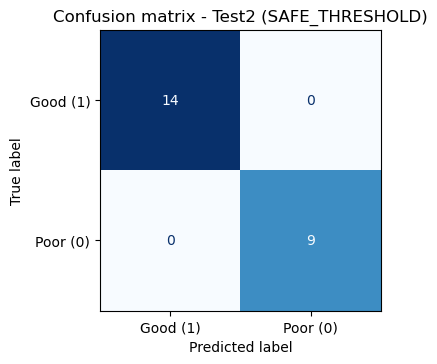

In [27]:
cm = confusion_matrix(y_true, y_pred_test2, labels=[1, 0])  # GOOD first
print(cm)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Good (1)", "Poor (0)"]  # pořadí odpovídá labels=[1,0]
)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Confusion matrix - Test2 (SAFE_THRESHOLD)")
plt.tight_layout()
plt.show()

In [28]:

# --- Basic metrics ---
accuracy  = accuracy_score(y_true, y_pred_test2)              # overall accuracy
balanced  = balanced_accuracy_score(y_true, y_pred_test2)     # mean of sensitivity & specificity

# --- Class-specific metrics ---
# Sensitivity = recall for GOOD (class 1): ability to correctly detect good-quality samples
sensitivity_good = recall_score(y_true, y_pred_test2, pos_label=1)

# Specificity = recall for POOR (class 0): ability to correctly detect poor-quality samples
specificity_poor = recall_score(y_true, y_pred_test2, pos_label=0)

# --- Error rates ---
# FNR (False Negative Rate): GOOD misclassified as POOR
FNR = 1 - sensitivity_good

# FPR (False Positive Rate): POOR misclassified as GOOD
FPR = 1 - specificity_poor

# --- Precision and F1 for GOOD samples ---
precision_good = precision_score(y_true, y_pred_test2, pos_label=1)
f1_good        = f1_score(y_true, y_pred_test2, pos_label=1)

# --- Print results ---
print(f"Accuracy:           {accuracy:.3f}")
print(f"Balanced accuracy:  {balanced:.3f}")
print(f"Sensitivity (GOOD): {sensitivity_good:.3f}")
print(f"Specificity (POOR): {specificity_poor:.3f}")
print(f"FNR (GOOD→POOR):    {FNR:.3f}")
print(f"FPR (POOR→GOOD):    {FPR:.3f}")
print(f"Precision (GOOD):    {f1_good:.3f}")

Accuracy:           1.000
Balanced accuracy:  1.000
Sensitivity (GOOD): 1.000
Specificity (POOR): 1.000
FNR (GOOD→POOR):    0.000
FPR (POOR→GOOD):    0.000
Precision (GOOD):    1.000


In [29]:
auc_test2 = roc_auc_score(y_test2, scores_test2)
print("ROC AUC (Test2):", auc_test2)


ROC AUC (Test2): 1.0


----
----

#### Task 12: TEST1-23 evaluation

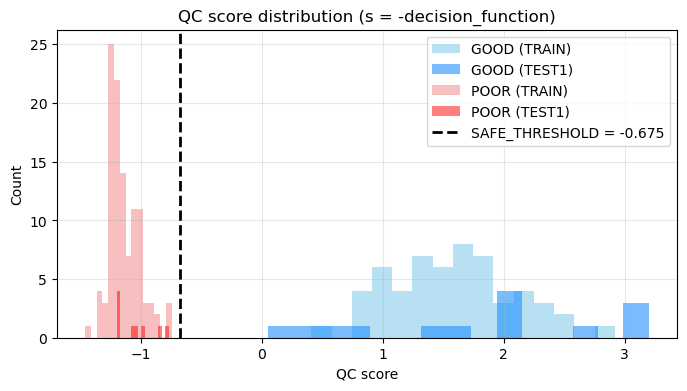

In [30]:
plt.figure(figsize=(8,4))

# Histogram GOOD
plt.hist(
    scores_train[y_train == 1], bins=15, alpha=0.6,
    color="skyblue", label="GOOD (TRAIN)"
)

plt.hist(
    scores_test1[y_test1 == 1], bins=15, alpha=0.6,
    color="dodgerblue", label="GOOD (TEST1)"
)

# Histogram POOR
plt.hist(
    scores_train[y_train == 0], bins=15, alpha=0.5,
    color="lightcoral", label="POOR (TRAIN)"
)

plt.hist(
    scores_test1[y_test1 == 0], bins=15, alpha=0.5,
    color="red", label="POOR (TEST1)"
)

# Safe threshold
plt.axvline(
    SAFE_THRESHOLD, color="black", linestyle="--", linewidth=2,
    label=f"SAFE_THRESHOLD = {SAFE_THRESHOLD:.3f}"
)

plt.title("QC score distribution (s = -decision_function)")
plt.xlabel("QC score")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


----

#### Task 13: TEST1-23 prediction values

In [31]:
# --- PREDICTED CLASSES FOR TEST1 ---
print("=== TEST1 PREDICTIONS ===")

y_pred_test1 = (scores_test1 > SAFE_THRESHOLD).astype(int)   # GOOD = 1, POOR = 0

# List predicted GOOD samples
print("\nPredicted GOOD (1):")
for sid, score, pred in zip(X_test1.index, scores_test1, y_pred_test1):
    if pred == 1:
        print(f"{sid}: score={score:.3f}")

# List predicted POOR samples
print("\nPredicted POOR (0):")
for sid, score, pred in zip(X_test1.index, scores_test1, y_pred_test1):
    if pred == 0:
        print(f"{sid}: score={score:.3f}")

# --- PREDICTED CLASSES FOR TEST2 ---
print("\n\n=== TEST2 PREDICTIONS ===")

y_pred_test2 = (scores_test2 > SAFE_THRESHOLD).astype(int)

print("\nPredicted GOOD (1):")
for sid, score, pred in zip(X_test2.index, scores_test2, y_pred_test2):
    if pred == 1:
        print(f"{sid}: score={score:.3f}")

print("\nPredicted POOR (0):")
for sid, score, pred in zip(X_test2.index, scores_test2, y_pred_test2):
    if pred == 0:
        print(f"{sid}: score={score:.3f}")


=== TEST1 PREDICTIONS ===

Predicted GOOD (1):
1_EDTA pre T0: score=3.196
2_EDTA pre T0: score=2.709
3_EDTA preT0: score=3.199
6_EDTA pre T0: score=3.107
7_EDTA pre T0: score=2.141
8759 EDTA val T0: score=1.991
8760 EDTA val T0: score=2.023
8761 EDTA val T0: score=1.952
8762 EDTA val T0: score=1.512
8764 EDTA val T0: score=1.584
1_EDTA pre T6: score=0.310
2_EDTA pre T6: score=0.521
3_EDTA pre T6: score=0.815
4_EDTA pre T6: score=0.054

Predicted POOR (0):
1_EDTA pre T24: score=-1.076
2_EDTA pre T24: score=-1.028
3_EDTA pre T24: score=-0.835
4_EDTA pre T24: score=-1.170
5_EDTA pre T24: score=-0.770
7_EDTA pre T24: score=-0.981
8759 EDTA val T24: score=-1.173
8760 EDTA val T24: score=-1.196
8762 EDTA val T24: score=-1.197


=== TEST2 PREDICTIONS ===

Predicted GOOD (1):
EDTA 8759-0: score=2.159
EDTA 8760-0: score=2.402
EDTA 8761-0: score=2.346
EDTA 8762-0: score=1.831
EDTA 8764-0: score=1.778
EDTA T0 1: score=2.619
EDTA T0 2: score=2.695
EDTA T0 3: score=3.168
EDTA T0 6: score=3.045
EDTA

----
----

#### Task 14: Visualization of safe threshold

PCA visualizations are provided for illustrative purposes only. Sample classification and threshold selection are based exclusively on the distribution of SVM decision (QC) scores.

Model loaded.
Loaded SAFE_THRESHOLD: -0.6750643265606378
PCA shapes: (165, 2) (23, 2)
PCA saved to: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\models\pca2.joblib


c:\Users\UserPhD\anaconda3\envs\predikce_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


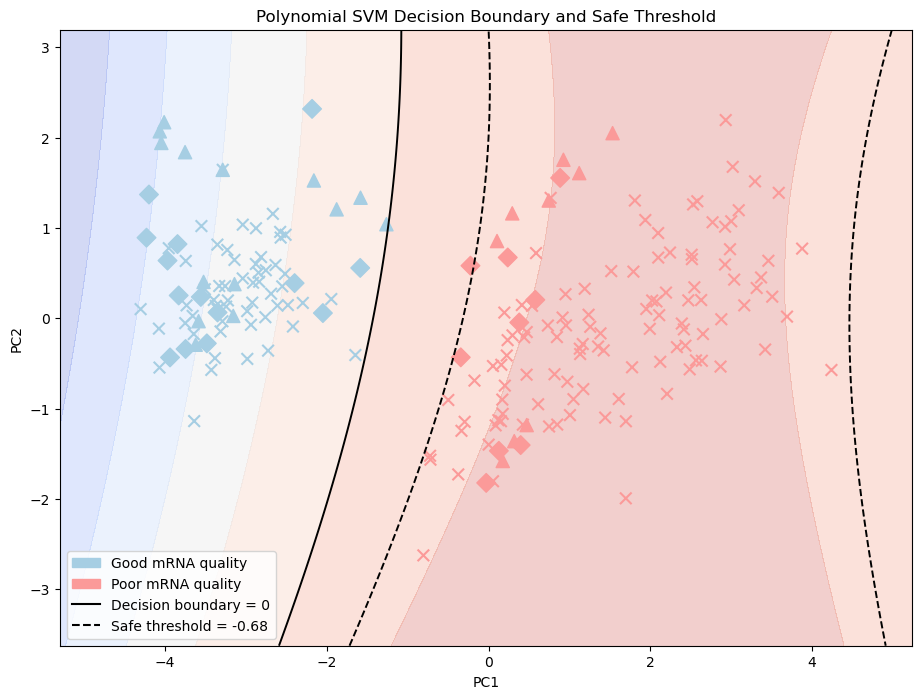

In [32]:
# ============================================
# 0. Load model, data, safe threshold
# ============================================

reloaded_pipeline = joblib.load(MODEL_PATH)
print("Model loaded.")

scaler = reloaded_pipeline.named_steps["scaler"]
model  = reloaded_pipeline.named_steps["model"]

# Data
train_df  = pd.read_csv(TRAIN_PATH, index_col=0)
test1_df  = pd.read_csv(TEST1_PATH, index_col=0)
test2_df  = pd.read_csv(TEST2_PATH, index_col=0)

feature_cols = scaler.feature_names_in_

X_train = train_df[feature_cols]
y_train = train_df["groups"].astype(int)

X_test1 = test1_df[feature_cols]
y_test1 = test1_df["groups"].astype(int)

X_test2 = test2_df[feature_cols]
y_test2 = test2_df["groups"].astype(int)

# Decision scores
scores_train = reloaded_pipeline.decision_function(X_train)
scores_test1 = reloaded_pipeline.decision_function(X_test1)
scores_test2 = reloaded_pipeline.decision_function(X_test2)

with THRESHOLD_PATH.open("r", encoding="utf-8") as f:
    SAFE_THRESHOLD = float(json.load(f)["SAFE_THRESHOLD"])

print("Loaded SAFE_THRESHOLD:", SAFE_THRESHOLD)


# ============================================
# 1. PCA for visualization (fit ONLY on TRAIN)
# ============================================

X_train_scaled = scaler.transform(X_train)
X_test1_scaled = scaler.transform(X_test1)
X_test2_scaled = scaler.transform(X_test2)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test1_pca = pca.transform(X_test1_scaled)
X_test2_pca = pca.transform(X_test2_scaled)

print("PCA shapes:", X_train_pca.shape, X_test2_pca.shape)


# ============================================
# 2. Save PCA for Notebook 3
# ============================================

PCA_PATH = MODELS_DIR / "pca2.joblib"
joblib.dump(pca, PCA_PATH)
print("PCA saved to:", PCA_PATH)


# ============================================
# 3. Compute decision surface in PCA space
# ============================================

# Define grid limits
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid_pca = np.c_[xx.ravel(), yy.ravel()]
grid_scaled   = pca.inverse_transform(grid_pca)
grid_unscaled = scaler.inverse_transform(grid_scaled)

Z_scores = reloaded_pipeline.decision_function(grid_unscaled).reshape(xx.shape)


# ============================================
# 4. Plot (Train/Test1/Test2 + decision boundary)
# ============================================

COLOR_GOOD = "#a6cee3"
COLOR_POOR = "#fb9a99"

plt.figure(figsize=(11, 8))
plt.title("Polynomial SVM Decision Boundary and Safe Threshold")


# Background shading
plt.contourf(xx, yy, Z_scores, cmap="coolwarm_r", alpha=0.25)

# Decision boundary (score = 0)
plt.contour(xx, yy, Z_scores,
            levels=[0],
            colors="black",
            linewidths=1.4,
            linestyles="solid")

# Safe threshold (score = SAFE_THRESHOLD)
plt.contour(xx, yy, Z_scores,
            levels=[SAFE_THRESHOLD],
            colors="black",
            linewidths=1.4,
            linestyles="dashed")


# TRAIN
plt.scatter(
    X_train_pca[:, 0], X_train_pca[:, 1],
    c=np.where(y_train == 1, COLOR_GOOD, COLOR_POOR),
    marker="x", s=70, label="Train"
)

# TEST1
plt.scatter(
    X_test1_pca[:, 0], X_test1_pca[:, 1],
    c=np.where(y_test1 == 1, COLOR_GOOD, COLOR_POOR),
    marker="^", s=90, label="Test1"
)

# TEST2
plt.scatter(
    X_test2_pca[:, 0], X_test2_pca[:, 1],
    c=np.where(y_test2 == 1, COLOR_GOOD, COLOR_POOR),
    marker="D", s=90, label="Test2"
)


# Legend
patch_good = mpatches.Patch(color=COLOR_GOOD, label="Good mRNA quality")
patch_poor = mpatches.Patch(color=COLOR_POOR, label="Poor mRNA quality")

line_boundary = Line2D([0], [0], color="black", linestyle="solid", label="Decision boundary = 0")
line_safe     = Line2D([0], [0], color="black", linestyle="dashed", label=f"Safe threshold = {SAFE_THRESHOLD:.2f}")

plt.legend(handles=[patch_good, patch_poor, line_boundary, line_safe],
           loc="lower left")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



----
----